In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import config


from intraday_handler import (
	intraday_read_csv_correct_time,
	intraday_feature_trend,
	intraday_expected_cum_rvol,
	intraday_rvol
)

from intraday_viz import(
	intraday_feature_trend_viz,
	intraday_rvol_viz,
)


In [2]:
stock_ticker = config.STOCK_TICKER
look_back_days_hourly = 14

In [3]:
df_rth = intraday_read_csv_correct_time(config.INTRADAY_FILEPATH)

In [4]:
## default config 1 month intraday data
df_rth = intraday_read_csv_correct_time(config.INTRADAY_FILEPATH)
intraday_volume_df = intraday_feature_trend(df_rth, "volume",look_back_days_hourly)
intraday_expected_cum_rvol_df = intraday_expected_cum_rvol(df_rth, look_back_days_hourly)

In [5]:
sigma_rolling_window = 20

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def intraday_rvol(
    min_df: pd.DataFrame,
    exp_cum_df: pd.DataFrame,
    look_back_days: int,
    sigma_rolling_window: int,
    ema: bool
) -> pd.DataFrame:
    """
    Computes Intraday_RVOL = CumVolume / Expected_Cum_Vol.
    Then computes per-time-of-day mean (mu), sigma, and z-score across days.
    """
    # -- Prepare base frame
    df = min_df[["close", "volume"]].copy().sort_index()
    df["Date"] = df.index.date
    df["Time"] = df.index.time
    df["CumVolume"] = df.groupby("Date")["volume"].cumsum()

    # -- Join expected cumulative (already computed elsewhere)
    col_exp = f"Expected_Cum_Vol_{look_back_days}"
    joined = df.join(exp_cum_df[[col_exp]], how="left")

    # -- Intraday RVOL (cumulative)
    rvol_col = f"Intraday_RVOL_{look_back_days}"
    joined[rvol_col] = joined["CumVolume"] / joined[col_exp]

    # --- Compute μ and σ across days PER time-of-day (columns = time bins)
    # pivot: rows = Date, cols = Time, values = rvol
    rvol_pivot = joined.pivot_table(index="Date", columns="Time", values=rvol_col)

    if ema:
        # EMA mean & std across *days* for each time bin; shift to avoid using today's row
        rvol_mu = rvol_pivot.ewm(span=sigma_rolling_window, adjust=False).mean().shift(1)
        # For a stable EMA-based std, use EMA of squared deviations:
        # std ≈ sqrt( EMA( (x - mu)^2 ) ), also shifted by 1
        dev2 = (rvol_pivot - rvol_mu)**2
        rvol_sigma = dev2.ewm(span=sigma_rolling_window, adjust=False).mean().shift(1).pow(0.5)
    else:
        rvol_mu = rvol_pivot.rolling(window=sigma_rolling_window, min_periods=3).mean().shift(1)
        rvol_sigma = rvol_pivot.rolling(window=sigma_rolling_window, min_periods=3).std(ddof=0).shift(1)

    # stack back to long
    mu_long = rvol_mu.stack().rename("rvol_mu").reset_index()
    sig_long = rvol_sigma.stack().rename("rvol_sigma").reset_index()
    stats = pd.merge(mu_long, sig_long, on=["Date","Time"], how="inner")

    # merge stats back to the joined timestamps
    joined_stats = joined.merge(stats, on=["Date","Time"], how="left")

    # -- z-score
    z_col = f"{rvol_col}_z"
    joined_stats[z_col] = (joined_stats[rvol_col] - joined_stats["rvol_mu"]) / joined_stats["rvol_sigma"].replace(0, np.nan)

    # keep useful columns
    keep = ["close","volume","CumVolume", col_exp, rvol_col, "rvol_mu", "rvol_sigma", z_col, "Date", "Time"]
    return joined_stats[keep]

In [7]:
intraday_rvol_df = intraday_rvol(df_rth, intraday_expected_cum_rvol_df, look_back_days_hourly, sigma_rolling_window, ema=True)
intraday_rvol_df

,close,volume,CumVolume,Expected_Cum_Vol_14,Intraday_RVOL_14,rvol_mu,rvol_sigma,Intraday_RVOL_14_z,Date,Time
0,153.5001,2361682.0,2361682.0,NaN,NaN,NaN,NaN,NaN,2025-08-07,10:00:00
1,151.9150,1588514.0,3950196.0,NaN,NaN,NaN,NaN,NaN,2025-08-07,11:00:00
2,152.1100,1163869.0,5114065.0,NaN,NaN,NaN,NaN,NaN,2025-08-07,12:00:00
3,153.1600,576608.0,5690673.0,NaN,NaN,NaN,NaN,NaN,2025-08-07,13:00:00
4,152.6700,558516.0,6249189.0,NaN,NaN,NaN,NaN,NaN,2025-08-07,14:00:00
...,...,...,...,...,...,...,...,...,...,...
142,110.7400,805913.0,6337884.0,4.125531e+06,1.536259,0.864857,0.364150,1.843753,2025-09-05,12:00:00
143,112.2950,806046.0,7143930.0,4.862055e+06,1.469323,0.880066,0.384571,1.532248,2025-09-05,13:00:00
144,114.2000,871444.0,8015374.0,5.497781e+06,1.457929,0.885190,0.389168,1.471702,2025-09-05,14:00:00
145,114.5100,1097604.0,9112978.0,6.822628e+06,1.335699,0.892010,0.378966,1.170790,2025-09-05,15:00:00


/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_67719/709365770.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sub["Time_dt"] = pd.to_datetime(sub["Time"].astype(str))
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_67719/709365770.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sub["Time_dt"] = pd.to_datetime(sub["Time"].astype(str))
/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_67719/709365770.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sub["Time_dt"] = pd.to_datetime(sub["Time"].astype(str))
/var/folders/sr/t9b4x2mn7

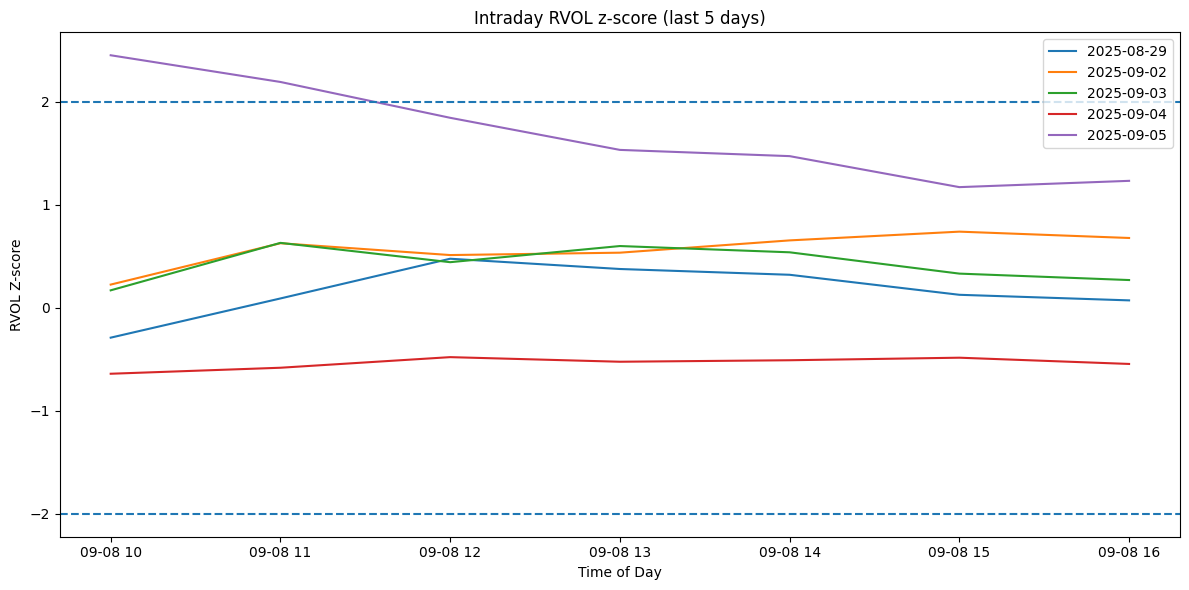

In [10]:
def plot_intraday_rvol_z_lines(rvol_df: pd.DataFrame, lookback_days: int = 5):
    """
    Plots z-score vs intraday time, one line per date (last N days).
    Expects columns: ['Date','Time', '..._z'] from intraday_rvol().
    """
    # auto-detect the z column name
    z_col = [c for c in rvol_df.columns if c.endswith("_z")][0]
    recent_days = sorted(rvol_df["Date"].unique())[-lookback_days:]

    plt.figure(figsize=(12,6))
    for d in recent_days:
        sub = rvol_df[rvol_df["Date"] == d].copy()
        # Ensure proper time ordering
        sub["Time_dt"] = pd.to_datetime(sub["Time"].astype(str))
        sub = sub.sort_values("Time_dt")
        plt.plot(sub["Time_dt"], sub[z_col], label=str(d))

    plt.axhline( 2, linestyle="--")
    plt.axhline(-2, linestyle="--")
    plt.title(f"Intraday RVOL z-score (last {lookback_days} days)")
    plt.xlabel("Time of Day")
    plt.ylabel("RVOL Z-score")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    
plot_intraday_rvol_z_lines(intraday_rvol_df, lookback_days=5)

In [11]:
def plot_intraday_rvol_z_heatmap(rvol_df: pd.DataFrame, days: int = 10):
    """
    Heatmap of z-score by date (rows) and time of day (cols).
    """
    z_col = [c for c in rvol_df.columns if c.endswith("_z")][0]
    recent_days = sorted(rvol_df["Date"].unique())[-days:]
    sub = rvol_df[rvol_df["Date"].isin(recent_days)].copy()

    # pivot for heatmap
    sub["Time_str"] = sub["Time"].astype(str)
    heat = sub.pivot_table(index="Date", columns="Time_str", values=z_col, aggfunc="mean")

    plt.figure(figsize=(14, max(3, 0.4*len(recent_days))))
    plt.imshow(heat.values, aspect="auto", interpolation="nearest")
    plt.colorbar(label="RVOL Z-score")
    plt.yticks(range(len(heat.index)), [str(d) for d in heat.index])
    plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
    plt.title(f"Intraday RVOL Z-score Heatmap (last {days} days)")
    plt.xlabel("Time of Day")
    plt.ylabel("Date")
    plt.tight_layout()
    plt.show()

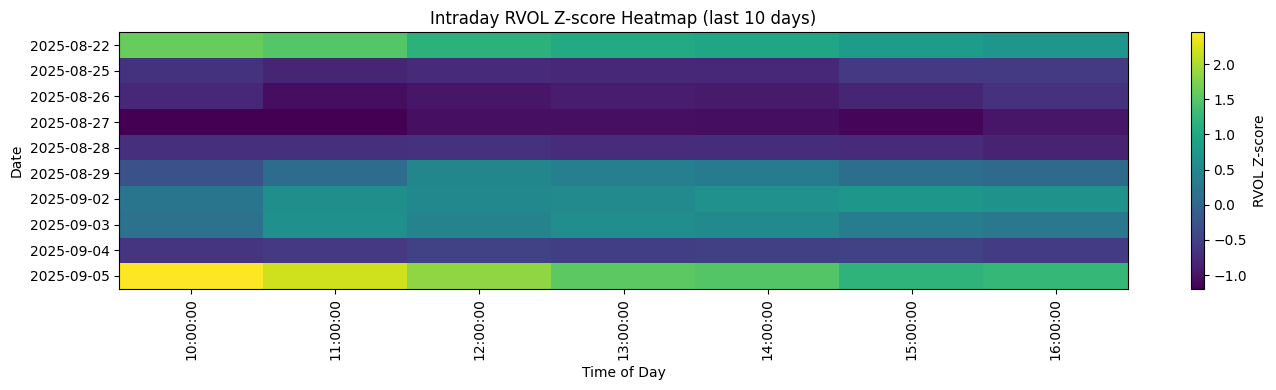

In [14]:
plot_intraday_rvol_z_heatmap(intraday_rvol_df, days=10)